In [8]:
import pandas as pd
import numpy as np
import os

In [79]:
HOME_PATH = os.getenv("HOME")
WORKSPACE_PATH = os.path.join(HOME_PATH, "workspace/rag_poc")
FILE_PATH = os.path.join(WORKSPACE_PATH, "BA_사용메뉴얼_분석가.pdf")

In [13]:
def show_metadata(docs):
    if docs:
        print("[metadata]")
        print(list(docs[0].metadata.keys()))
        print("\n[examples]")
        max_key_length = max(len(k) for k in docs[0].metadata.keys())
        for k, v in docs[0].metadata.items():
            print(f"{k:{max_key_length}}: {v}")

## 성능 비교

reference: https://wikidocs.net/253707

### PyPDF
```
!pip install -qU pypdf

!pip install -qU rapidocr-onnxruntime
```

In [31]:
from langchain_community.document_loaders import PyPDFLoader

# 파일 경로 설정
loader = PyPDFLoader(FILE_PATH) # extract_images=True 로 설정하면 이미지 추출 가능

# PDF 로더 초기화
docs = loader.load()

# 문서의 내용 출력
print(docs[20].page_content[:300])

8. 데이터  압축해제  업로드  
등록하고자  하는  파일이  압축된  경우 , 데이터로  등록하는  과정에서  압축을  해제하여  등록할  수  있습니다 
Upload Resource 에서  zip 파일을  선택하고  하단의  Unzip 에  체크합니다 
압축을  해제하여  데이터로  등록된  것을  확인  할  수  있습니다 


### PyPDF OCR

- 10분 소요
- 인식률이 높지 않음

In [40]:
# # 10분 소요
# from langchain_community.document_loaders import PyPDFLoader

# # 파일 경로 설정
# loader_ocr = PyPDFLoader(FILE_PATH,  extract_images=True) # extract_images=True 로 설정하면 이미지 추출 가능

# # PDF 로더 초기화
# docs_ocr = loader.load()

# # 문서의 내용 출력
# print(docs_ocr[20].page_content[:300])

### PyMuPDF
```
pip install PyMuPDF
```

- 이미지 저장

In [38]:
import fitz

# 저장할 폴더 이름
IMG_CONTENT_PATH = os.path.join(WORKSPACE_PATH, "image_content")

# 폴더가 존재하지 않으면 생성
if not os.path.exists(IMG_CONTENT_PATH):
    os.makedirs(IMG_CONTENT_PATH)

pdf_document = fitz.open(FILE_PATH)

# 각 페이지를 순회하며 이미지 추출
for page_number in range(len(pdf_document)):
    page = pdf_document.load_page(page_number)
    images = page.get_images(full=True)
    for img_index, img in enumerate(images):
        xref = img[0]
        base_image = pdf_document.extract_image(xref)
        image_bytes = base_image["image"]
        image_ext = base_image["ext"]
        # 이미지 저장
        file_name = f"image_page{page_number+1}_{img_index+1}.{image_ext}"

        with open(os.path.join(IMG_CONTENT_PATH, file_name), "wb") as image_file:
            image_file.write(image_bytes)

In [41]:
# 이미지 파일 목록 출력
image_files = os.listdir(IMG_CONTENT_PATH)
print(len(image_files))

449


### Unstrutured

```
pip install -qU unstructured
```

### PyMuPDF4LLM

In [87]:
import pymupdf4llm
md_text = pymupdf4llm.to_markdown(FILE_PATH, write_images=True, image_path=IMG_CONTENT_PATH)

Processing /home/taejong_kim/workspace/rag_poc/BA_사용메뉴얼_분석가.pdf...
[                                        ] (0/27[                                        ] (  1/27[                                        ] (  2/27[                                        ] (  3/27[                                        ] (  4/27[                                        ] (  5/27[                                        ] (  6/275[=                                       ] (  7/2[=                                       ] (  8/2[=                                       ] (  9/2[=                                       ] ( 10/2[=                                       ] ( 11/2[=                                       ] ( 12/275[=                                       ] ( 13/27[==                                      ] ( 14/27[==                                      ] ( 15/27[==                                      ] ( 16/27[==                                      ] ( 17/27[==                                   

In [137]:
import re

splited_markdonw = [item for item in re.split(r'(?<!##)##(?!##)', md_text) if item!='']
# print([13])

In [141]:
from langchain.schema import Document

def extract_images_and_create_documents(text):
    """
    Markdown 텍스트에서 ![]() 형식의 이미지를 추출하고, 
    본문과 이미지 리스트를 LangChain Document 객체로 변환
    """
    # 이미지 패턴 탐색 (예: ![alt text](image_url))
    image_pattern = re.compile(r'!\[.*?\]\((.*?)\)')
    
    # 이미지 리스트 추출
    images = image_pattern.findall(text)
    
    # 본문에서 이미지 태그 제거
    cleaned_text = image_pattern.sub('', text).strip()

    # LangChain Document 생성
    return Document(page_content=cleaned_text, metadata={"images": images})

docs4md = []
for md in splited_markdonw:
    doc = extract_images_and_create_documents(md)
    docs4md.append(doc)
    

## VecorDB

In [156]:
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.llms import HuggingFaceHub

load_dotenv()

True

- numpy 버전이 문제가 되는 경우가 있음
- 아래 오류 발생 시 numpy 버전을 업그레이드
```
error: module 'numpy' has no attribute '_no_nep50_warning'
```

버전 업그레이드
```
pip install --upgrade numpy scipy scikit-learn transformers sentence-transformers
```

In [147]:
huggingface_api_key = os.getenv("HUGGINGFACE_API_KEY")
google_api_key = os.getenv("GOOGLE_API_KEY")

In [157]:
hf = HuggingFaceEmbeddings(model_name='jhgan/ko-sroberta-multitask')

vectorstore = FAISS.from_documents(docs4md, embedding=hf) # hugging face의 무료 embedding 모델을 사용용
retriever = vectorstore.as_retriever()

In [161]:
query = "튜토리얼은 어떻게 보나요?"
retriever.get_relevant_documents(query, top_k=5)

[Document(id='5a6414a5-08f4-488d-933b-021a0641b73d', metadata={'images': []}, page_content='02. 튜토리얼\n\n1. 튜토리얼 위치\n\n2. 튜토리얼 구성'),
 Document(id='5c2e4011-1318-4082-8d35-ab36333f956b', metadata={'images': []}, page_content='목록\n\n1. 튜토리얼 위치\n\n2. 튜토리얼 구성'),
 Document(id='b1024fe7-259f-4580-8057-cccecca90520', metadata={'images': ['/home/taejong_kim/workspace/rag_poc/image_content/BA_사용메뉴얼_분석가.pdf-9-0.png', '/home/taejong_kim/workspace/rag_poc/image_content/BA_사용메뉴얼_분석가.pdf-10-0.png']}, page_content='2. 튜토리얼 구성\n\n튜토리얼은 동영상으로 구성되어 있고 각 항목을 선택하면 해당 동영상이 열립니다\n\n\n\n\n-----\n\n\n\n-----\n\n# 기본기능 > 데이터'),
 Document(id='a7b71d80-9d71-443b-bc2b-9d0e693ad890', metadata={'images': []}, page_content='1. 튜토리얼 위치\n\n튜토리얼은 사용자 가이드로 메인 헤더 우측 바로가기 선택 메뉴에 있습니다')]

### 프롬프트 구성

In [162]:
template = """Answer the question based only on the following context:
{context}
 
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [163]:
llm = ChatGoogleGenerativeAI(model="gemini-pro")

In [164]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
retriever.get_relevant_documents(query, top_k=5)

[Document(id='071cdd83-1fea-4c51-9759-d7726afd1a63', metadata={'images': []}, page_content='2. Script작성\n\n변수에 설정된 파일 경로로 파일을 쓰기 위한 스크립트를 작성합니다'),
 Document(id='6518de7d-9cfa-4a13-b931-0149071550d2', metadata={'images': []}, page_content='1. 스크립트 작성\n\n스크립트 작성은 단일 Plot 생성 Script와 유사합니다'),
 Document(id='c1083238-0fe7-4ea4-a0ea-aa72ccc63b7d', metadata={'images': ['/home/taejong_kim/workspace/rag_poc/image_content/BA_사용메뉴얼_분석가.pdf-120-0.png', '/home/taejong_kim/workspace/rag_poc/image_content/BA_사용메뉴얼_분석가.pdf-121-1.png', '/home/taejong_kim/workspace/rag_poc/image_content/BA_사용메뉴얼_분석가.pdf-121-0.png', '/home/taejong_kim/workspace/rag_poc/image_content/BA_사용메뉴얼_분석가.pdf-122-0.png', '/home/taejong_kim/workspace/rag_poc/image_content/BA_사용메뉴얼_분석가.pdf-122-0.png', '/home/taejong_kim/workspace/rag_poc/image_content/BA_사용메뉴얼_분석가.pdf-123-1.png']}, page_content='2. 스크립트 작성\n\n등록된 Zip파일 경로를 resource 타입의 Attribute로 추가합니다\n\n\n\n\n-----\n\n\n\n압축 해제를 위한 카테고리를 생성하고, resource 타입의 Attribute로 추가합니다\n\n\n\n\

제공된 텍스트에서는 스크립트 작성 방법에 대한 정보가 없습니다.


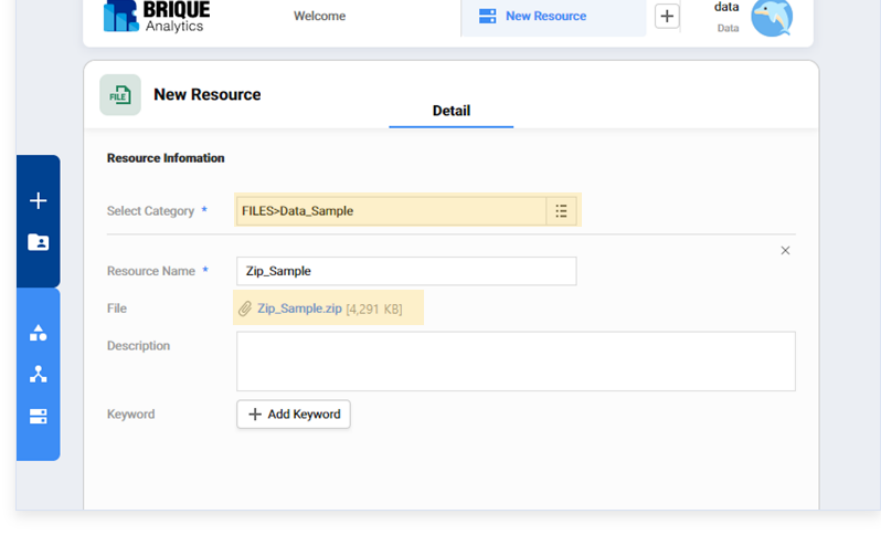

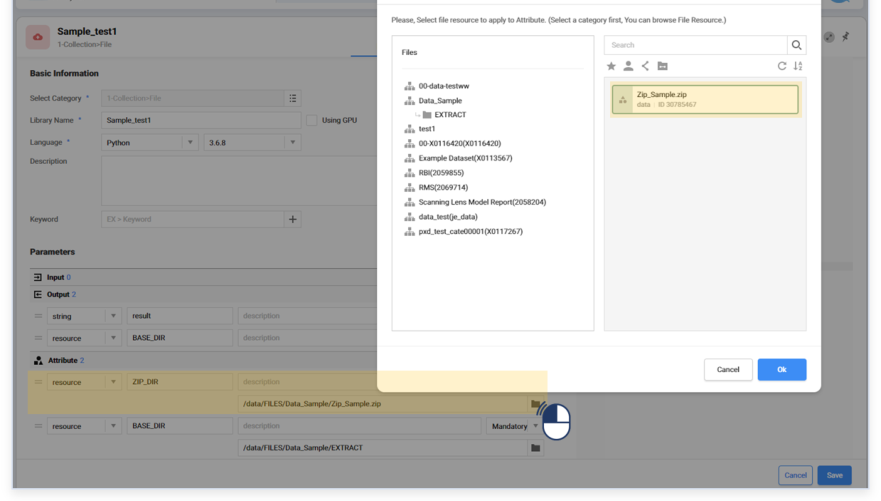

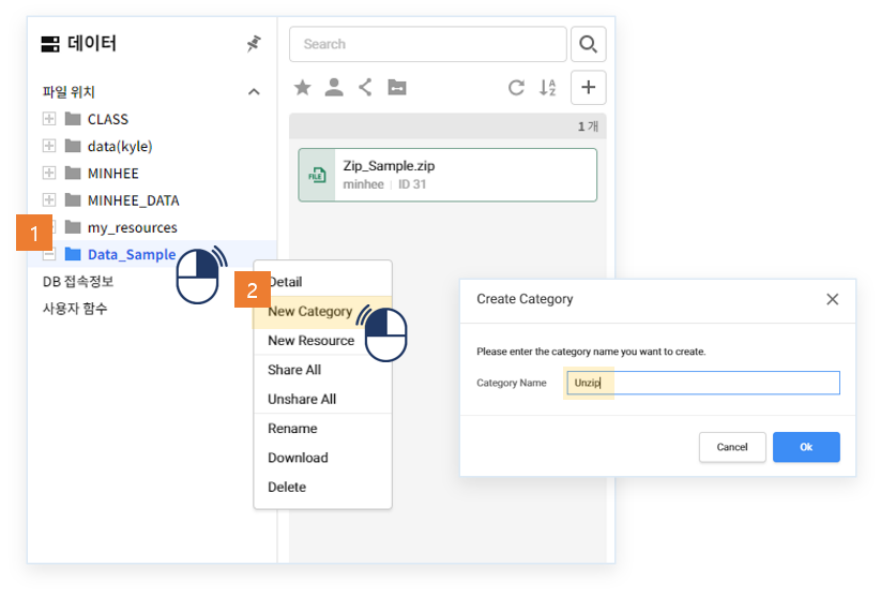

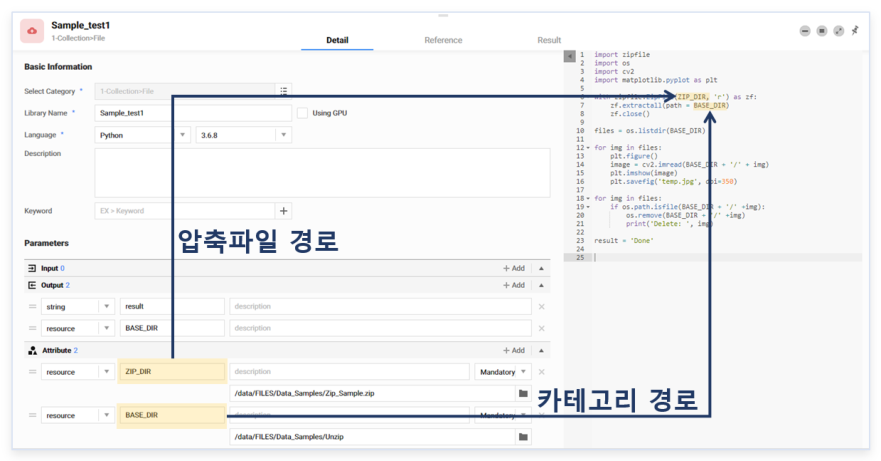

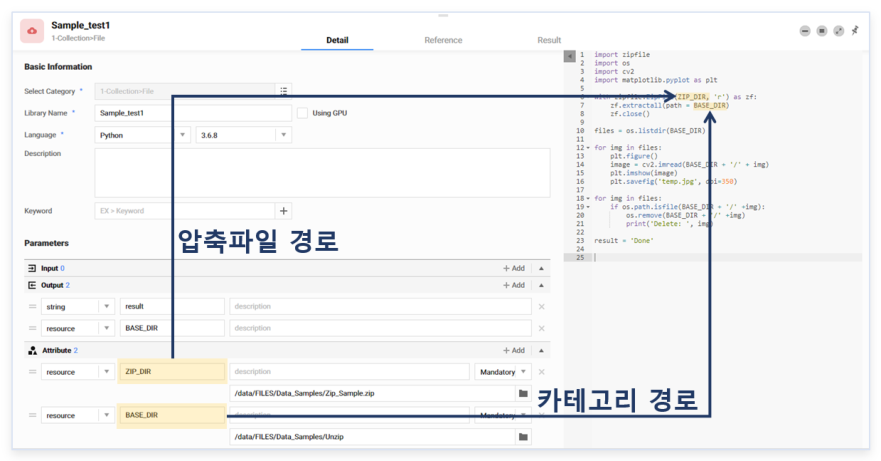

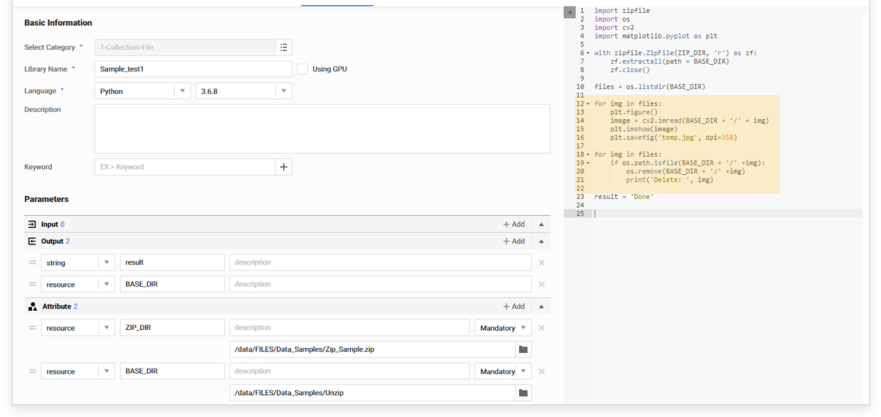

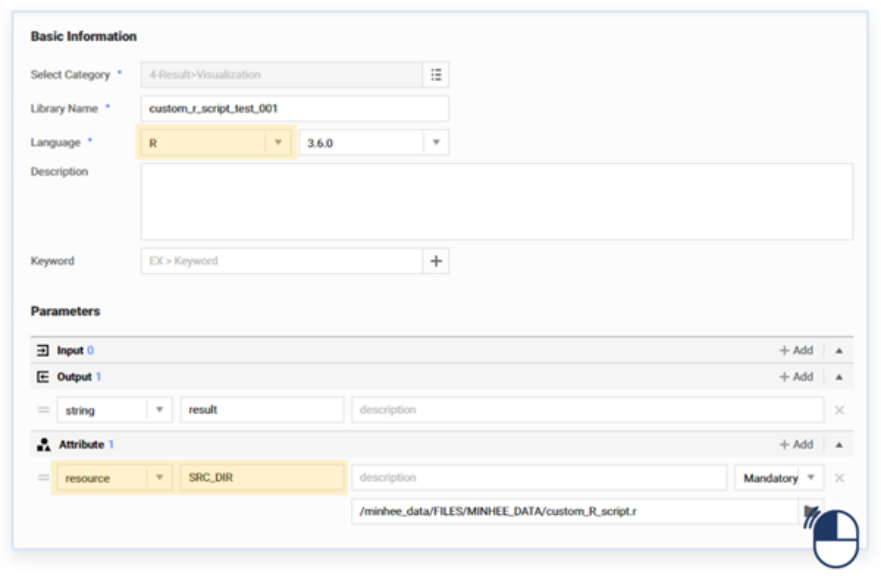

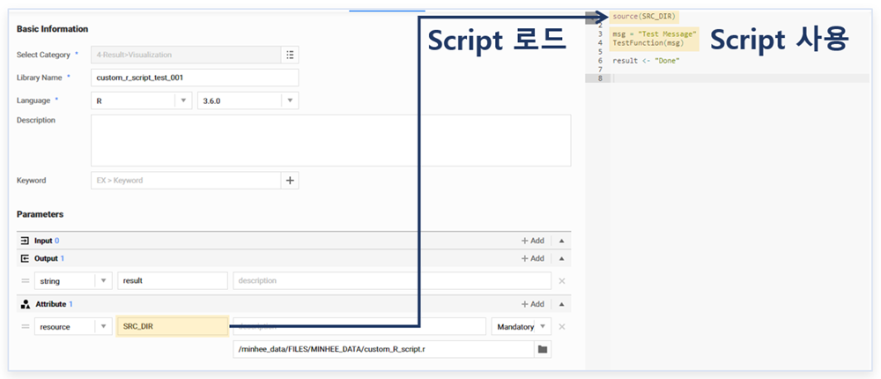

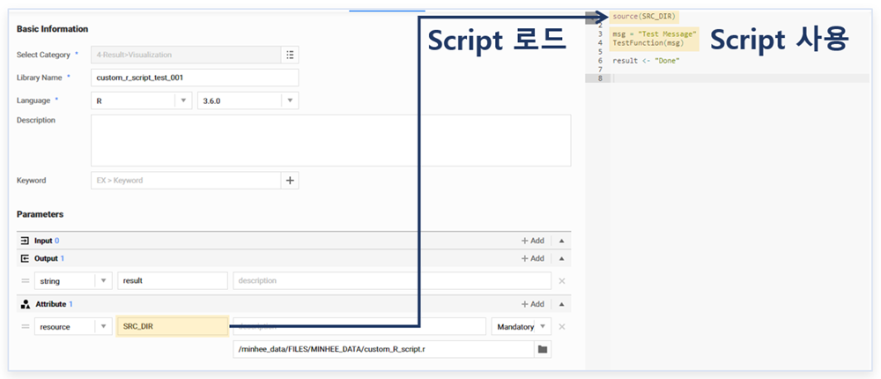

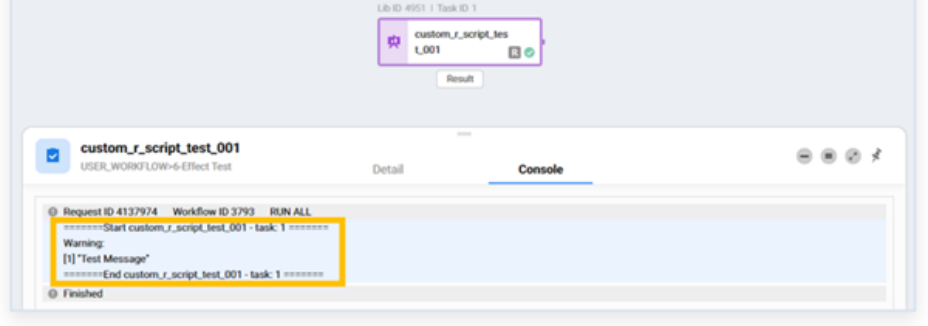

In [ ]:
from PIL import Image

query = "스크립트 작성방법을 알려줘"

print(chain.invoke(query))

for doc in retriever.get_relevant_documents(query, top_k=5):
    imgs = doc.metadata["images"]
    if len(imgs) > 0:
        # print(f"Images: {imgs}")
        for img in imgs:
            image = Image.open(img)
            image.show()